In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [ ]:
#data used:
#https://data.ecb.europa.eu/data/datasets/YC/YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_3M?chart_props=W3sibm9kZUlkIjoiMTg5NTYzMSIsInByb3BlcnRpZXMiOlt7ImNvbG9ySGV4IjoiIiwiY29sb3JUeXBlIjoiIiwiY2hhcnRUeXBlIjoibGluZWNoYXJ0IiwibGluZVN0eWxlIjoiU29saWQiLCJsaW5lV2lkdGgiOiIxLjUiLCJheGlzUG9zaXRpb24iOiJsZWZ0Iiwib2JzZXJ2YXRpb25WYWx1ZSI6ZmFsc2UsImRhdGVzIjpbIjIwMjItMDYtMTJUMjI6MDA6MDAuMDAwWiIsIjIwMjQtMDYtMTJUMjI6MDA6MDAuMDAwWiJdLCJpc1RkYXRhIjpmYWxzZSwibW9kaWZpZWRVbml0VHlwZSI6IiIsInllYXIiOiJkYXRld2lzZSIsInN0YXJ0RGF0ZSI6IjIwMjItMDYtMTMiLCJlbmREYXRlIjoiMjAyNC0wNi0xMyIsInNldERhdGUiOnRydWUsInNob3dUYWJsZURhdGEiOnRydWUsImNoYW5nZU1vZGUiOmZhbHNlLCJzaG93TWVudVN0eWxlQ2hhcnQiOmZhbHNlLCJkaXNwbGF5TW9iaWxlQ2hhcnQiOnRydWUsInNjcmVlblNpemUiOiJtYXgiLCJzY3JlZW5XaWR0aCI6MTUzNiwic2hvd1RkYXRhIjpmYWxzZSwidHJhbnNmb3JtZWRGcmVxdWVuY3kiOiJub25lIiwidHJhbnNmb3JtZWRVbml0Ijoibm9uZSIsImZyZXF1ZW5jeSI6Im5vbmUiLCJ1bml0Ijoibm9uZSIsIm1vZGlmaWVkIjoiZmFsc2UiLCJzZXJpZXNLZXkiOiJkYWlseSAtIGJ1c2luZXNzd2VlayIsInNob3d0YWJsZVN0YXRlQmVmb3JlTWF4U2NyZWVuIjp0cnVlLCJpc2RhdGFjb21wYXJpc29uIjpmYWxzZSwic2VyaWVzRnJlcXVlbmN5IjoiZGFpbHkgLSBidXNpbmVzc3dlZWsiLCJpbnRpYWxTZXJpZXNGcmVxdWVuY3kiOiJkYWlseSAtIGJ1c2luZXNzd2VlayIsIm1ldGFkYXRhRGVjaW1hbCI6IjYiLCJpc1RhYmxlU29ydGVkIjpmYWxzZSwiaXNZZWFybHlUZGF0YSI6ZmFsc2UsInJlc3BvbnNlRGF0YUVuZERhdGUiOiIiLCJpc2luaXRpYWxDaGFydERhdGEiOnRydWUsImlzRGF0ZXNGcm9tRGF0ZVBpY2tlciI6dHJ1ZSwiZGF0ZVBpY2tlckVuZERhdGUiOiIyMDI0LTA2LTEzIiwiaXNEYXRlUGlja2VyRW5kRGF0ZSI6dHJ1ZSwic2VyaWVza2V5U2V0IjoiIiwiZGF0YXNldElkIjoiMTI1IiwiaXNDYWxsYmFjayI6ZmFsc2UsImlzU2xpZGVyVGRhdGEiOnRydWUsImlzU2xpZGVyRGF0YSI6dHJ1ZSwiaXNJbml0aWFsQ2hhcnREYXRhRnJvbUdyYXBoIjp0cnVlLCJjaGFydFNlcmllc0tleSI6IllDLkIuVTIuRVVSLjRGLkdfTl9BLlNWX0NfWU0uU1JfM00iLCJ0eXBlT2YiOiIifV19XQ%3D%3D

In [ ]:
import os

current_dir = os.path.dirname(__file__)
data_path = os.path.join(current_dir, 'data', 'data.csv')

In [78]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize


class SDE():
    """
    Class designed to represents Stochastic Differential Equation in form of: dX_t = mu(X_t, t)*dt+sigma(X_t, t)dWt
    where mu function is a drift, sigma is diffusion and Wt is Brownian motion. Each class object needs to have specified all
    necesary constants separetly for each function and functions mu and sigma depending on model type.
    """
    def __init__(self, drift,
                 set_of_constants_drift,
                 diffusion, 
                 set_of_constants_diffusion,
                 diffusion_prime, 
                 set_of_constants_diffusion_prime):
        """
            drift: function
        function of 3 elements: (X_t, t, set_of_constants_drift) that represents true model drift function
            set_of_constants_drift: list
        user gives set of constants that will be used in the model
            diffusion: function
        function of 3 elements: (X_t, t, set_of_constants_diffusion)
            set_of_constants_diffusion: list
        list of parametres used in function sigma
            diffusion_prime: function
        Function ONLY of X_t and set_of_constants_diffusion_prime. This function must be computed by user but only in case when
        diffusion function is independent of time argument. Then diffusion_pime is derivative of diffusion over X_t.
            set_of_constants_diffusion_prime: list
        list of constants used in diffusion_prime function
        """
        self.drift = drift
        self.set_of_constants_drift = set_of_constants_drift
        self.diffusion = diffusion
        self.set_of_constants_diffusion = set_of_constants_diffusion
        self.diffusion_prime = diffusion_prime
        self.set_of_constants_diffusion_prime = set_of_constants_diffusion_prime

    def drift_val(self, X_t, t, arg):

        return self.drift(X_t, t, arg)
    def diffusion_val(self, X_t, t, arg):
        """
        Functions used to evaluate values of given functions for different arguments, very useful later
        """
        return self.diffusion(X_t, t, arg)
    def diffusion_prime_val(self, X_t, arg):
        """
        Functions used to evaluate values of given functions for different arguments, very useful later
        """
        return self.diffusion_prime(X_t, arg)


    def simulate_paths(self, name, T, x0, N=None, delta_t=None, random=1, drift_pars=None, diffusion_pars=None):
        """
        Function returns single path of simulated time series using Milstein or Euler scheme
        
        
            name: str, either "Euler" or "Milstein"
            T: float
        Time interval, in case daily values it is just difference in days between first and last observation
            x0: float
        Value from which simulation should begin. First element in simulated series
            N: int
        Number of subintervals (arguments) that will be considered in simulated series
            delta_t: float
        Interval length between 2 time arguments. Either delta_t must be given by user or N. Code will throw error otherwise
            random: 1 or 0
        0 means that user wants to recieve values without random parameter, just "mean" process. Random 1 just gives clasic 
        Euler or Milstein series approximation and returns paths with noice
            drift_pars: None, but can be set
        On default it follows set of parameters in drift function in __init__ bus user has possibility to change it
        here if needed.
            diffusion_pars: None, but can be set
        On default it follows set of parameters in diffusion function in __init__ bus user has possibility to change it
        here if needed.           
        """
        if diffusion_pars is None:
            diffusion_pars = self.set_of_constants_diffusion
        if drift_pars is None:
            drift_pars = self.set_of_constants_drift

        if delta_t is None and N is None:
            raise ValueError("Either delta_t or N need to be given")
        if delta_t is not None and N is not None:
            if delta_t != T / N:
                raise ValueError("Both N and delta_t were given, but they do not match each other")
        if delta_t is None:
            delta_t = T / N
        elif N is None:
            N = int(T / delta_t)

        if random not in [1, 0]:
            raise ValueError("random parameter must be either 1 or 0")

        t_list = []
        X_t_list = [x0]
        if random:
            No = np.random.normal(0, 1, N)
            W = np.zeros(N)
            for i in range(1, N):
                W[i] = W[i-1] + (delta_t ** 0.5) * No[i-1]
        else:
            W = np.zeros(N)

        if name == 'Euler':
            for periods in range(1, N):
                t = periods * delta_t
                t_list.append(t)
                a = self.drift_val(X_t_list[-1], t, drift_pars)
                b = self.diffusion_val(X_t_list[-1], t, diffusion_pars)
                dW = W[periods] - W[periods - 1]
                X_t_list.append(X_t_list[-1] + a * delta_t + random * b * (dW))
        elif name == 'Milstein':
            for periods in range(1, N):
                t = periods * delta_t
                t_list.append(t)
                a = self.drift_val(X_t_list[-1], t, drift_pars)
                b = self.diffusion_val(X_t_list[-1], t, diffusion_pars)
                b_W_t = self.diffusion_val(W[periods], t, diffusion_pars)
                b_prime = self.diffusion_prime_val(X_t_list[-1], diffusion_pars)
                dW = W[periods] - W[periods - 1]
                X_t_list.append(X_t_list[-1] * a * delta_t + b_W_t * dW + 0.5 * random * b_prime * b * (dW**2 - delta_t))
                # wykonanie tego w praktyce to dramat jakiś
        else:
            raise ValueError("Only 'Euler' and 'Milstein' approximation are available")

        return X_t_list

    def estimate_drift_par(self, dataset, function=lambda x, y: (x - y) ** 2):
        """
        Function designed to estimate drift parameters of SDE. It search such values that minimize given function (on default it is 
        the sum of squared difference) between "mean" process on time interval from dataset and values of dataset.

            dataset: pandas.DataFrame or DataSeries object
        Dataset that is used to estimate drift parameters for given SDE model
            function: function of 2 arguments
        Function that is used to evaluate error
        """
    
        #support function that will be minimized
        def objective(drift_const):
            mean_process = self.simulate_paths(name='Euler', T=len(dataset), N=len(dataset), x0=dataset.iloc[0], random=0, drift_pars=drift_const)
            error_list = [function(mean_process[time], dataset.iloc[time]) for time in range(len(dataset))]
            return sum(error_list)
        
        # Assuming drift_const is an initial guess or array of initial guesses for the drift parameters
        initial_guess = self.set_of_constants_drift  # Adjust according to your use case
        result = minimize(objective, initial_guess, method='BFGS')
        self.drift_otpimized=result.x
        return result.x

    def estimate_diffusion_par_weighted_estimator(self, dataset, weights_set=None, ):   
        """
        This approach asumes that volatility is estimated from the past and will be evaluated as weighted standard deviation.
        Also it is crucial here that in the model function b is just a constant and that is why this approach is resonable.
        
        dataset: DataSeries or dictionary
        the data from witch user want to estimate sigma in the model. 
        
        weights_set: list
        set of weights that will be used to estimate standard deviation. Very last element in the list refers to the last
        observation in the dataset and follows reverse order
        """
        if weights_set is None:
            weights_set = ([(9/10)**i for i in range(len(dataset)-1,-1,-1)])
        estimated_with_drift = self.simulate_paths(name='Euler', T=len(dataset), N=len(dataset), x0=dataset.iloc[0], random=0, drift_pars=self.drift_otpimized)
#        if drift_pars is None:
#            drift_pars = self.drift_otpimized
        numerator=0
        for time in range(len(weights_set)):
            numerator += weights_set[time] * (estimated_with_drift[time]-dataset.iloc[time])**2
        std_est=(numerator/((len(weights_set)-1)*sum(weights_set)))**(1/2)
        self.diffusion_estimated = std_est
        return std_est

    
class IRVal():
    """
    Class follows the structure from csv file downloaded from webside
    """
    def __init__(self, data): #ready csv file downloaded from the webside 
        self.dataset = data
    def prepare_data(self):
        self.dataset = self.dataset.iloc[:,1]
        self.dataset = self.dataset.rename({"Yield curve spot rate, 3-month maturity - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_3M)":"Yield curve spot rate, 3-month maturity"})
    def set_time_horizon(self, beginning, end):
        self.time_beginning = beginning
        self.time_end = end    
        return self.dataset.loc[self.time_beginning:self.time_end]
    def return_number_of_observations(self):
        if self.time_beginning in self.dataset.index and self.time_end in self.dataset.index:
            first_day = self.dataset.index.get_loc(self.time_beginning)
            last_day = self.dataset.index.get_loc(self.time_end)
            observation_num_difference = abs(last_day - first_day)
            self.N = observation_num_difference
        else:
            raise ValueError('Please make sure that your dates are given in correct form YYYY-MM-DD')        


In [88]:
#data preparation using IRVal class
csv = pd.read_csv("C:/Users/dawid/Desktop/data.csv", index_col=["DATE"])
data = IRVal(csv)  
data.prepare_data()
t_0 = "2024-02-13"
t_1 = "2024-06-13"
restrcted = data.set_time_horizon(t_0,t_1)
data.set_time_horizon(t_0,t_1)
data.return_number_of_observations() 


#vasicek model preparation
def drift_vasicek(x, t, drift_const):
    return drift_const[0]*(drift_const[1]-x)
#diffusion_const = (sigmna)
def diffusion_vasicek(X_t, t, diffusion_const):
    return diffusion_const[0]
diffusion_prime_const = None
def diffusion_prime_vasicek(X_t, diffusion_prime_const):
    return 0    
drift_default = [0.01, 3]
diff_default = [1]
diff_prime_default = [0]

#creating model
vasicek = SDE(drift_vasicek, drift_default, diffusion_vasicek, diff_default, diffusion_prime_vasicek, diff_prime_default)
daata = vasicek.simulate_paths(T = len(restrcted), name = 'Euler', x0 = float(restrcted.iloc[0]), N=len(restrcted), random=0)

([<matplotlib.axis.XTick at 0x1aa5c661cd0>,
 [Text(0.0, 0, '2024-02-13'),
  Text(5.0, 0, '2024-02-20'),
  Text(10.0, 0, '2024-02-27'),
  Text(15.0, 0, '2024-03-05'),
  Text(20.0, 0, '2024-03-12'),
  Text(25.0, 0, '2024-03-19'),
  Text(30.0, 0, '2024-03-26'),
  Text(35.0, 0, '2024-04-04'),
  Text(40.0, 0, '2024-04-11'),
  Text(45.0, 0, '2024-04-18'),
  Text(50.0, 0, '2024-04-25'),
  Text(55.0, 0, '2024-05-03'),
  Text(60.0, 0, '2024-05-10'),
  Text(65.0, 0, '2024-05-17'),
  Text(70.0, 0, '2024-05-24'),
  Text(75.0, 0, '2024-05-31'),
  Text(80.0, 0, '2024-06-07')])

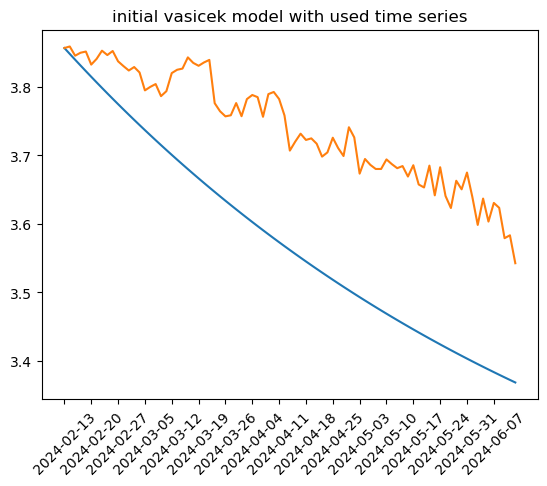

In [89]:
plt.plot(restrcted.index, daata)
plt.plot(restrcted)
plt.title('initial vasicek model with used time series')
plt.xticks(restrcted.index[::5], rotation=45)

In [81]:
#estimate drift parameter using Euler scheme that minimizes sum of squared errors
est_drift = vasicek.estimate_drift_par(dataset = restrcted)
est_drift

array([ 4.74126045e-05, -5.66791820e+01])

In [82]:
#estimate diffusion parameter using Euler scheme with weighted std estimator with given weights_set (geometric sequence of (9/10)**n)
diff_est = vasicek.estimate_diffusion_par_weighted_estimator(dataset = restrcted, weights_set = ([(9/10)**i for i in range(len(daata)-1,-1,-1)]))
diff_est = [diff_est]

In [90]:
#vasicek model with estimated parameters
vasicek_fitted = SDE(drift_vasicek, est_drift, diffusion_vasicek, diff_est, diffusion_prime_vasicek, diff_prime_default)
estimated_model = vasicek_fitted.simulate_paths(T = len(restrcted), name = 'Euler', x0 = float(restrcted.iloc[0]), N=len(restrcted), random=0)

([<matplotlib.axis.XTick at 0x1aa58c86a10>,
 [Text(0.0, 0, '2024-02-13'),
  Text(5.0, 0, '2024-02-20'),
  Text(10.0, 0, '2024-02-27'),
  Text(15.0, 0, '2024-03-05'),
  Text(20.0, 0, '2024-03-12'),
  Text(25.0, 0, '2024-03-19'),
  Text(30.0, 0, '2024-03-26'),
  Text(35.0, 0, '2024-04-04'),
  Text(40.0, 0, '2024-04-11'),
  Text(45.0, 0, '2024-04-18'),
  Text(50.0, 0, '2024-04-25'),
  Text(55.0, 0, '2024-05-03'),
  Text(60.0, 0, '2024-05-10'),
  Text(65.0, 0, '2024-05-17'),
  Text(70.0, 0, '2024-05-24'),
  Text(75.0, 0, '2024-05-31'),
  Text(80.0, 0, '2024-06-07')])

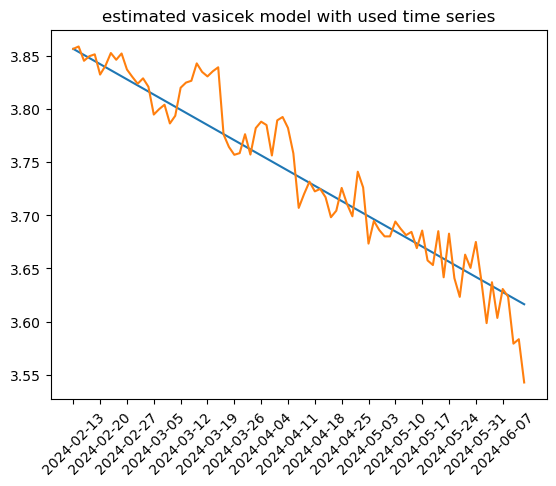

In [91]:
plt.plot(restrcted.index, estimated_model)
plt.plot(restrcted)
plt.title('estimated vasicek model with used time series')
plt.xticks(restrcted.index[::5], rotation=45)

In [85]:
#seting number of perios that user wants to estimate values in
number_of_periods_in_future = 15

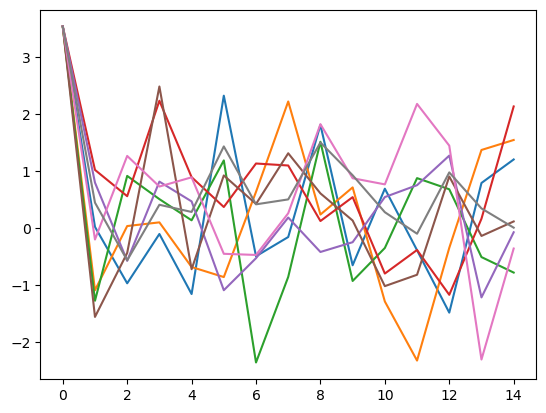

In [92]:
#creating the best model and simulating paths using Milstein scheme 
vasicek_est = SDE(drift_vasicek, est_drift, diffusion_vasicek, [diff_est], diffusion_prime_vasicek, [0])
for paths in range(8):
    path_est_milstein = vasicek.simulate_paths(T = number_of_periods_in_future, name = 'Milstein', x0 = float(restrcted.iloc[-1]), N=number_of_periods_in_future, random=1)
    plt.plot(path_est_milstein)

The problem with Milstein may be connected with fact that parameters were wstimated using Euler scheme and may not work that well in Milstein case

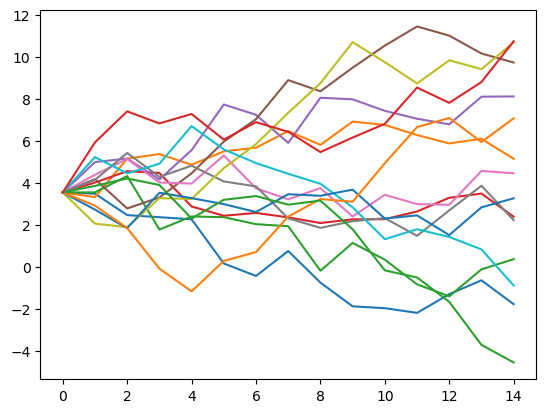

In [93]:
#Simulating paths using Euler scheme 
for paths in range(14):
    path_est_euler = vasicek.simulate_paths(T = number_of_periods_in_future, name = 'Euler', x0 = float(restrcted.iloc[-1]), N=number_of_periods_in_future, random=1)
    plt.plot(path_est_euler)